<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Segmenting and Clustering Neighborhoods in Toronto</font></h1>

### Step 2 - Use the Notebook to build the code to scrape the following Wikipedia page

In [1]:
#Install Beautifulsoup version 4
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
!pip install requests

#Import the necessary libraries
import pandas as pd
import numpy as np
import itertools

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
%matplotlib inline

Get the data from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
from bs4 import BeautifulSoup
import requests

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [4]:
soup = BeautifulSoup(source,'lxml')
table = soup.find('table')

Clean up the data first
- The dataframe will consist of three columns: Postal Code, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [5]:
data = list()

#loop through looking for the tag for rows (i.e., 'tr')
for rows in table.find_all('tr'):
    #loop through lookin for the tag for data (i.e., 'td')
    row = rows.find_all('td')
    #grab/strip out the postal code, borough, and neighborhood
    if row:
        postalcode = row[0].text.rstrip()
        borough = row[1].text.rstrip()
        neighborhood = row[2].text.rstrip()
        #If the data is there, append it; only process rows that have a borough assigned
        if borough != 'Not assigned':
            #To deal with the situation where there is not a neighborhood, give the neighborhood the value of the borough
            if neighborhood == 'Not assigned':
                neighborhood = borough
            data.append([postalcode, borough, neighborhood])

#Grab the column headers (this will be used in creating the dataframe)
col_head = list()
for cols in table.tr.find_all('th'):
    col_head.append(cols.text.strip())

#Print out the column headers
col_head

['Postal code', 'Borough', 'Neighborhood']

Convert this into a dataframe

In [6]:
df = pd.DataFrame(data, columns = col_head)

In [7]:
#Look at what we have so far (we will need to )
df.describe()

,Postal code,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M9P,North York,Downsview
freq,1,24,4


Note: More than one neighborhood can exist in one postal code area. These two rows will be combined into one row with the neighborhoods separated with a comma.

Merge the neighborhoods by using a custom groupby statement

In [8]:
df = df.groupby('Postal code').agg(
    {
        'Borough':'first',
        'Neighborhood': ','.join
    }
    ).reset_index()

In [9]:
# df.groupby('Postal code')['Neighborhood'].agg(','.join)

In [10]:
#Look at what we have now
df.describe()

,Postal code,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M6E,North York,Downsview
freq,1,24,4


In [11]:
#Print out the first 5 rows, to see if the concatenation of neighborhoods is working
df.head()

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
#Rename "Postal code" to "Postalcode", so we can join with the latitude/longitude table further down
df.rename(columns={'Postal code':'Postalcode'}, inplace=True)

df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Use the .shape method to print the number of rows of your dataframe.

In [13]:
print(df.shape)

(103, 3)


### Step 3 - Incorporate the Latitude & Longitude Coordinates

In [14]:
#Download the geospatial data
!wget -q -O geospatial_data.csv http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


In [15]:
#Read the geospatial into a CSV file
dfgeo = pd.read_csv("geospatial_data.csv")
dfgeo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [17]:
#Rename the Postal Code field, so you can merge it with the neighborhood data table
dfgeo.rename(columns={'Postal Code': 'Postalcode'}, inplace = True)
dfgeo.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
dfmerged = pd.merge(df, dfgeo, on="Postalcode", how='left')
dfmerged.head(11)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park,43.727929,-79.262029
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge,43.711112,-79.284577
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,43.716316,-79.239476
9,M1N,Scarborough,Birch Cliff / Cliffside West,43.692657,-79.264848


### Step 4 - Explore and Cluster the Neighborhoods in Toronto

You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

In [19]:
#Install geopy
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

#Import the libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

#Transform the json file into a pandas dataframe
from pandas.io.json import json_normalize

#Install folium
!pip install folium
import folium

print()
print('Folium is installed.')
print()
print('The libraries are imported.')

     |████████████████████████████████| 92kB 7.7MB/s eta 0:00:011

Folium is installed.

The libraries are imported.


In [20]:
#Find the geolocation for Toronto, Canada
address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The longitude and latitude of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


The longitude and latitude of Toronto are 43.6534817, -79.3839347.


In [21]:
# Create a map of Canada using the latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

#Add markers to the map of Canada
for lat, lng, borough, neighborhood in zip(dfmerged['Latitude'], dfmerged['Longitude'], dfmerged['Borough'], dfmerged['Neighborhood']):
    label = '{}', '{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3).add_to(map_toronto)

#Display the map
map_toronto

Segment and cluster only on neighborhoods in Toronto

In [22]:
toronto_data = dfmerged[dfmerged['Borough'].str.contains("Toronto")]

toronto_data = dfmerged.reset_index(drop=True)

toronto_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [23]:
# Create a map of Toronto using the latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

#Add markers to the map of Canada
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}', '{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3).add_to(map_toronto)

#Display the map
map_toronto

## Define Foursquare Credentials and Version

In [24]:
CLIENT_ID = 'PX34EKN1YODZERJIGF5AWLHWHHLSNZBZUM53F3VWRFD1V4W0' # your Foursquare ID
CLIENT_SECRET = 'YTHIRHEHDCFMG4ML12GZZ3XDKVK3WFNMXYSZYOYVFYFJYOAE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PX34EKN1YODZERJIGF5AWLHWHHLSNZBZUM53F3VWRFD1V4W0
CLIENT_SECRET:YTHIRHEHDCFMG4ML12GZZ3XDKVK3WFNMXYSZYOYVFYFJYOAE


Let's explore the first neighborhood in our dataframe.  Get the neighborhood's name first.

In [25]:
toronto_data.loc[0, 'Neighborhood']

'Malvern / Rouge'

Get the neighborhood's longitude and latitude values

In [26]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Malvern / Rouge are 43.806686299999996, -79.19435340000001.


# Now, let's get the top 100 venues that are in the neighborhood within a radius of 500 meters

First, let's create the GET request URL. Name your URL url.

In [27]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=PX34EKN1YODZERJIGF5AWLHWHHLSNZBZUM53F3VWRFD1V4W0&client_secret=YTHIRHEHDCFMG4ML12GZZ3XDKVK3WFNMXYSZYOYVFYFJYOAE&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

Send the get request and examine the results

In [28]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e8fa8ba1d67cb001bdebef2'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': 'Wendy’s',
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

Extract the category of the venue

In [29]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a pandas dataframe

In [30]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056
1,T Hamilton & Son Roofing Inc,Construction & Landscaping,43.807985,-79.198194


In [31]:
print('Number of venues returned by Foursquare equals {}.'.format(nearby_venues.shape[0]))

Number of venues returned by Foursquare equals 2.


## Explore all the neighborhoods in Toronto

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues

In [34]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Malvern / Rouge
Rouge Hill / Port Union / Highland Creek
Guildwood / Morningside / West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park / Ionview / East Birchmount Park
Golden Mile / Clairlea / Oakridge
Cliffside / Cliffcrest / Scarborough Village West
Birch Cliff / Cliffside West
Dorset Park / Wexford Heights / Scarborough Town Centre
Wexford / Maryvale
Agincourt
Clarks Corners / Tam O'Shanter / Sullivan
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Steeles West / L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview / Henry Farm / Oriole
Bayview Village
York Mills / Silver Hills
Willowdale / Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor / Wilson Heights / Downsview North
Northwood Park / York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill / Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West / Riverdale
India Bazaar / The Beaches 

Check the size of the resulting data shape

In [35]:
print(toronto_venues.shape)
toronto_venues.head()

(2173, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Malvern / Rouge,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,Malvern / Rouge,43.806686,-79.194353,T Hamilton & Son Roofing Inc,43.807985,-79.198194,Construction & Landscaping
2,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,Guildwood / Morningside / West Hill,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,Guildwood / Morningside / West Hill,43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


How many venues were returned for each neighborhood

In [36]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
Alderwood / Long Branch,11,11,11,11,11,11
Bathurst Manor / Wilson Heights / Downsview North,20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,23,23,23,23,23,23
Berczy Park,56,56,56,56,56,56
Birch Cliff / Cliffside West,4,4,4,4,4,4
Brockton / Parkdale Village / Exhibition Place,22,22,22,22,22,22
Business reply mail Processing CentrE,17,17,17,17,17,17


Deternime how many unique categories can be curated from all the returned venues

In [37]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques categories.


## Analyze Each Neighborhood

In [38]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]


#toronto_onehot = pd.concat([toronto_venues['Neighborhood'], toronto_onehot], axis=1)

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
toronto_onehot.shape

(2173, 267)

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [40]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,Alderwood / Long Branch,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,Bathurst Manor / Wilson Heights / Downsview North,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.00000
3,Bayview Village,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,Bedford Park / Lawrence Manor East,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,Berczy Park,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
6,Birch Cliff / Cliffside West,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7,Brockton / Parkdale Village / Exhibition Place,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,Business reply mail Processing CentrE,0.058824,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
9,CN Tower / King and Spadina / Railway Lands / ...,0.000000,0.00000,0.000000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [41]:
toronto_grouped.shape

(95, 267)

Print each neighborhood along with the top 5 most common venues

In [42]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1  Latin American Restaurant  0.25
2             Breakfast Spot  0.25
3               Skating Rink  0.25
4              Metro Station  0.00


----Alderwood / Long Branch----
                venue  freq
0         Pizza Place  0.18
1  Athletics & Sports  0.09
2        Dance Studio  0.09
3            Pharmacy  0.09
4                Pool  0.09


----Bathurst Manor / Wilson Heights / Downsview North----
                       venue  freq
0                       Bank  0.10
1                Coffee Shop  0.10
2                Pizza Place  0.05
3  Middle Eastern Restaurant  0.05
4           Sushi Restaurant  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2   Chinese Restaurant  0.25
3  Japanese Restaurant  0.25
4  Moroccan Restaurant  0.00


----Bedford Park / Lawrence Manor East----
                venue  freq
0          Restaurant  0.09

Put that into a pandas dataframe

Write a function to sort the venues in descending order.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Build/display the top 10 venues in each neighborhood of Toronto

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,Alderwood / Long Branch,Pizza Place,Coffee Shop,Sandwich Place,Dance Studio,Pub,Athletics & Sports,Pool,Skating Rink,Pharmacy,Gym
2,Bathurst Manor / Wilson Heights / Downsview North,Coffee Shop,Bank,Shopping Mall,Pizza Place,Supermarket,Deli / Bodega,Sushi Restaurant,Middle Eastern Restaurant,Restaurant,Diner
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store
4,Bedford Park / Lawrence Manor East,Coffee Shop,Italian Restaurant,Restaurant,Sandwich Place,Sushi Restaurant,Greek Restaurant,Indian Restaurant,Fast Food Restaurant,Juice Bar,Liquor Store


## Cluster the Neighborhoods

In [45]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

In [46]:
# set number of clusters
kclusters = 5

min_inertia = np.zeros((kclusters-1))

for n in range(1,kclusters):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0, n_init=15).fit(toronto_grouped_clustering)
    min_inertia[n-1] = kmeans.inertia_

# display the minimum inertia    
min_inertia

array([18.54054134, 16.55165058, 14.86242443, 13.8839653 ])

Look for the "elbow" (i.e, the balance between clutering reability and inertia score)

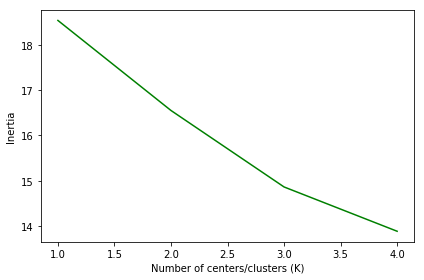

In [47]:
# 
# plot the inertia with the different k to find the better balance
#
plt.plot(range(1,kclusters),min_inertia,'g')
plt.ylabel('Inertia ')
plt.xlabel('Number of centers/clusters (K)')
plt.tight_layout()
plt.show()

Based on the graph above, it looks balance between clutering reability and inertia score is around 4 clusters

In [48]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=15).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Display the information on the centers

In [49]:
print("number of clusters:", len(kmeans.cluster_centers_))
#print("cluster center:" , kmeans.cluster_centers_)
print("number of iterations:", kmeans.n_iter_)
print("inertia (Sum of squared distances of samples to cluster center): ", kmeans.inertia_)

number of clusters: 4
number of iterations: 6
inertia (Sum of squared distances of samples to cluster center):  13.883965296548148


Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [50]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.astype({'Cluster Labels':'int32'},copy=False)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353,1.0,Fast Food Restaurant,Construction & Landscaping,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,3.0,Bar,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Farmers Market
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711,1.0,Rental Car Location,Intersection,Mexican Restaurant,Bank,Medical Center,Breakfast Spot,Electronics Store,Dumpling Restaurant,Drugstore,Donut Shop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean Restaurant,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Fried Chicken Joint,Thai Restaurant,Bank,Caribbean Restaurant,Athletics & Sports,Gas Station,Hakka Restaurant,Lounge,Bakery,Eastern European Restaurant


In [51]:
# display the number of borough per cluster
toronto_merged['Cluster Labels'].value_counts()

1.0    84
0.0    13
2.0     2
3.0     1
Name: Cluster Labels, dtype: int64

In [52]:
toronto_merged = toronto_merged.dropna()

# Visualize the resulting clusters

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[int(cluster)-1],
        fill=True,
        fill_color= rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster.

Cluster 1

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0.0,Park,Playground,Coffee Shop,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
23,North York,0.0,Park,Electronics Store,Bank,Convenience Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
25,North York,0.0,Park,Food & Drink Shop,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
40,East York,0.0,Park,Coffee Shop,Intersection,Convenience Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
44,Central Toronto,0.0,Park,Bus Line,Swim School,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dessert Shop
48,Central Toronto,0.0,Park,Summer Camp,Tennis Court,Trail,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega
50,Downtown Toronto,0.0,Park,Playground,Trail,Electronics Store,Eastern European Restaurant,Empanada Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega
64,Central Toronto,0.0,Park,Jewelry Store,Bus Line,Sushi Restaurant,Trail,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dessert Shop
72,North York,0.0,Park,Sushi Restaurant,Pub,Japanese Restaurant,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
74,York,0.0,Park,Market,Women's Store,Gluten-free Restaurant,Gift Shop,Electronics Store,Golf Course,Eastern European Restaurant,Dumpling Restaurant,Drugstore


Cluster 2

In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1.0,Fast Food Restaurant,Construction & Landscaping,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,Scarborough,1.0,Rental Car Location,Intersection,Mexican Restaurant,Bank,Medical Center,Breakfast Spot,Electronics Store,Dumpling Restaurant,Drugstore,Donut Shop
3,Scarborough,1.0,Coffee Shop,Korean Restaurant,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
4,Scarborough,1.0,Fried Chicken Joint,Thai Restaurant,Bank,Caribbean Restaurant,Athletics & Sports,Gas Station,Hakka Restaurant,Lounge,Bakery,Eastern European Restaurant
5,Scarborough,1.0,Spa,Playground,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
6,Scarborough,1.0,Discount Store,Department Store,Convenience Store,Chinese Restaurant,Coffee Shop,Bus Station,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dim Sum Restaurant
7,Scarborough,1.0,Bus Line,Soccer Field,Metro Station,Bakery,Bus Station,Intersection,Ice Cream Shop,Park,Donut Shop,Doner Restaurant
8,Scarborough,1.0,Motel,American Restaurant,Women's Store,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
9,Scarborough,1.0,Café,General Entertainment,Skating Rink,College Stadium,Concert Hall,Construction & Landscaping,Empanada Restaurant,Electronics Store,Comfort Food Restaurant,Eastern European Restaurant
10,Scarborough,1.0,Indian Restaurant,Pet Store,Vietnamese Restaurant,Furniture / Home Store,Chinese Restaurant,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


Cluster 3

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,2.0,Baseball Field,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Farmers Market
97,North York,2.0,Baseball Field,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Farmers Market


Cluster 4

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,3.0,Bar,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Farmers Market
